# Examine max wind speeds in CM2.6

## Problems with distributed

Using the threaded scheduler is currently the only way I can finish writing out zarr files. This is however quite slow (a lot more cores would help tremendously in speeding this up). 
I am trying to debug this in `cm26_pipeline-debug-distributed.ipynb`. For now I will use this as a brute force 'leave running all night' way to get anything to analyze.

In [2]:
import fsspec
import xarray as xr
import numpy as np
import xesmf as xe
import os
from intake import open_catalog
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
import gcsfs
from dask.diagnostics import ProgressBar

In [3]:
kwargs = dict(consolidated=True, use_cftime=True)
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
ds_ocean  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
ds_flux  = cat["GFDL_CM2_6_control_ocean_boundary_flux"].to_dask()
# xarray says not to do this
# ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', chunks={'time':1}, **kwargs)
ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', **kwargs)
ds_oc_grid  = cat["GFDL_CM2_6_grid"].to_dask()
# cut to same time
all_dims = set(list(ds_ocean.dims)+list(ds_atmos.dims))
ds_ocean, ds_atmos = xr.align(
    ds_ocean,
    ds_atmos,
    join='inner',
    exclude=(di for di in all_dims if di !='time')
)
# instead do this
ds_atmos = ds_atmos.chunk({'time':1})

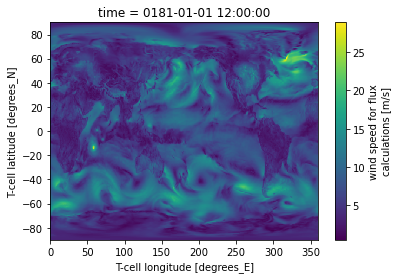

In [8]:
ds_atmos.wind.isel(time=0).plot()

[########################################] | 100% Completed | 24.0s


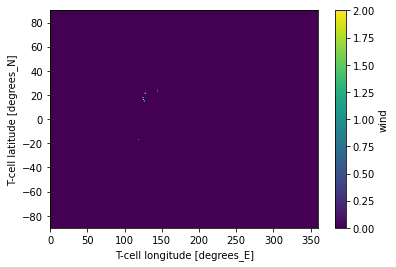

In [6]:
with ProgressBar():
    (ds_atmos.wind > 40).sum('time').plot(y='grid_yt')